In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
import requests
from io import StringIO

In [3]:
# FRED series codes and their corresponding maturities (in years)
fred_series = {
    "1M": ("DGS1MO", 1/12),
    "3M": ("DGS3MO", 3/12),
    "6M": ("DGS6MO", 6/12),
    "1Y": ("DGS1", 1),
    "2Y": ("DGS2", 2),
    "3Y": ("DGS3", 3),
    "5Y": ("DGS5", 5),
    "7Y": ("DGS7", 7),
    "10Y": ("DGS10", 10),
    "20Y": ("DGS20", 20),
    "30Y": ("DGS30", 30)
}

# Target date range: last 10 days (in case of holidays or missing values)
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - timedelta(days=10)).strftime("%Y-%m-%d")

# Download data and store the most recent non-null values
yields = {}
dates_used = {}

for label, (code, maturity) in fred_series.items():
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={code}&cosd={start_date}&coed={end_date}"
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text))
    print(f"\n{label} - Columns: {df.columns}")
    print(df.head())
    df = df.dropna()
    if not df.empty:
        latest_date = df['observation_date'].iloc[-1]
        latest_value = df[code].iloc[-1]
        yields[maturity] = latest_value
        dates_used[label] = latest_date
    else:
        print(f"No data for {label} ({code})")

# Convert to DataFrame and sort by maturity
yield_curve = pd.DataFrame(list(yields.items()), columns=["Maturity (Years)", "Yield (%)"])
yield_curve = yield_curve.sort_values("Maturity (Years)").reset_index(drop=True)

# Preview the result
yield_curve



1M - Columns: Index(['observation_date', 'DGS1MO'], dtype='object')
  observation_date  DGS1MO
0       2025-07-23    4.37
1       2025-07-24    4.37
2       2025-07-25    4.37
3       2025-07-28    4.40
4       2025-07-29    4.40

3M - Columns: Index(['observation_date', 'DGS3MO'], dtype='object')
  observation_date  DGS3MO
0       2025-07-23    4.41
1       2025-07-24    4.42
2       2025-07-25    4.42
3       2025-07-28    4.40
4       2025-07-29    4.40

6M - Columns: Index(['observation_date', 'DGS6MO'], dtype='object')
  observation_date  DGS6MO
0       2025-07-23    4.31
1       2025-07-24    4.32
2       2025-07-25    4.31
3       2025-07-28    4.30
4       2025-07-29    4.28

1Y - Columns: Index(['observation_date', 'DGS1'], dtype='object')
  observation_date  DGS1
0       2025-07-23  4.08
1       2025-07-24  4.10
2       2025-07-25  4.09
3       2025-07-28  4.09
4       2025-07-29  4.07

2Y - Columns: Index(['observation_date', 'DGS2'], dtype='object')
  observation_date  DGS

,Maturity (Years),Yield (%)
0,0.083333,4.49
1,0.250000,4.41
2,0.500000,4.31
3,1.000000,4.10
4,2.000000,3.94
5,3.000000,3.89
6,5.000000,3.96
7,7.000000,4.14
8,10.000000,4.37
9,20.000000,4.89


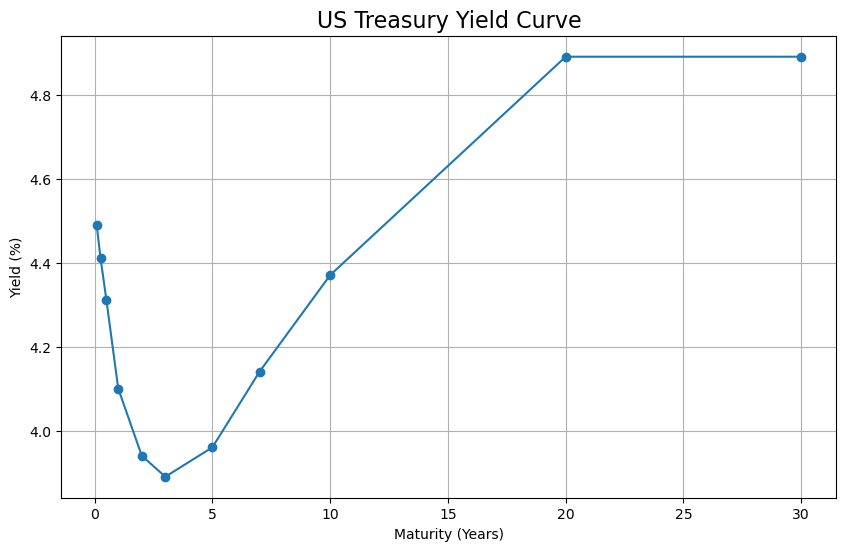

In [4]:
# Basic line plot of the current yield curve
plt.figure(figsize=(10, 6))
plt.plot(yield_curve["Maturity (Years)"], yield_curve["Yield (%)"], marker='o')
plt.title("US Treasury Yield Curve", fontsize=16)
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.show()


In [5]:
# Define reference date: x days ago
ref_date = (datetime.today() - timedelta(days=30)).strftime("%Y-%m-%d")
start_ref = (datetime.today() - timedelta(days=40)).strftime("%Y-%m-%d")  # 10-day buffer

# Repeat the fetch for historical data
past_yields = {}

for label, (code, maturity) in fred_series.items():
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={code}&cosd={start_ref}&coed={ref_date}"
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text))
    df = df.dropna()
    if not df.empty:
        past_value = df[code].iloc[-1]
        past_yields[maturity] = past_value
    else:
        print(f"No historical data for {label} ({code})")

# Convert to DataFrame
past_curve = pd.DataFrame(list(past_yields.items()), columns=["Maturity (Years)", "Yield (%)"])
past_curve = past_curve.sort_values("Maturity (Years)").reset_index(drop=True)


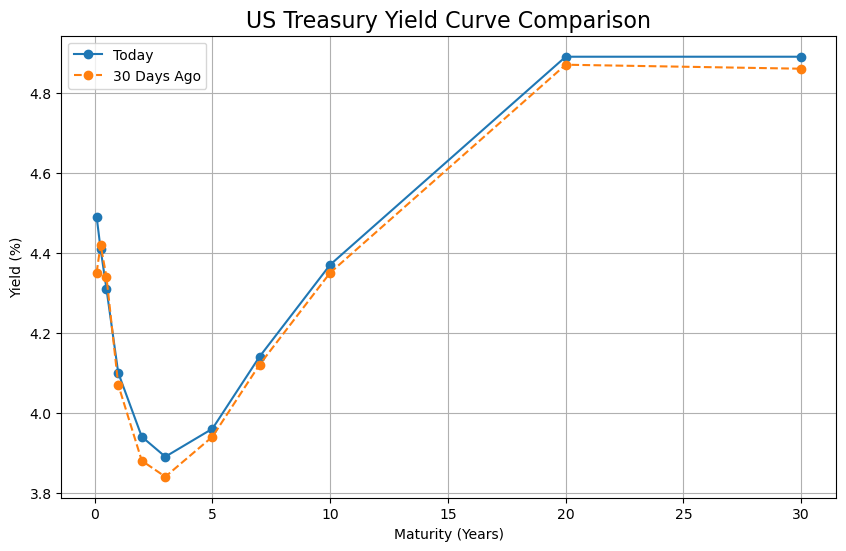

In [6]:
# Plot both current and past yield curves
plt.figure(figsize=(10, 6))
plt.plot(yield_curve["Maturity (Years)"], yield_curve["Yield (%)"], marker='o', label="Today")
plt.plot(past_curve["Maturity (Years)"], past_curve["Yield (%)"], marker='o', linestyle='--', label="30 Days Ago")
plt.title("US Treasury Yield Curve Comparison", fontsize=16)
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend()
plt.show()


In [7]:
from scipy.interpolate import interp1d

# Build interpolation function from current curve
x = yield_curve["Maturity (Years)"]
y = yield_curve["Yield (%)"]

# Linear interpolation — can switch to kind='cubic' later
interp_func = interp1d(x, y, kind='linear', fill_value="extrapolate")


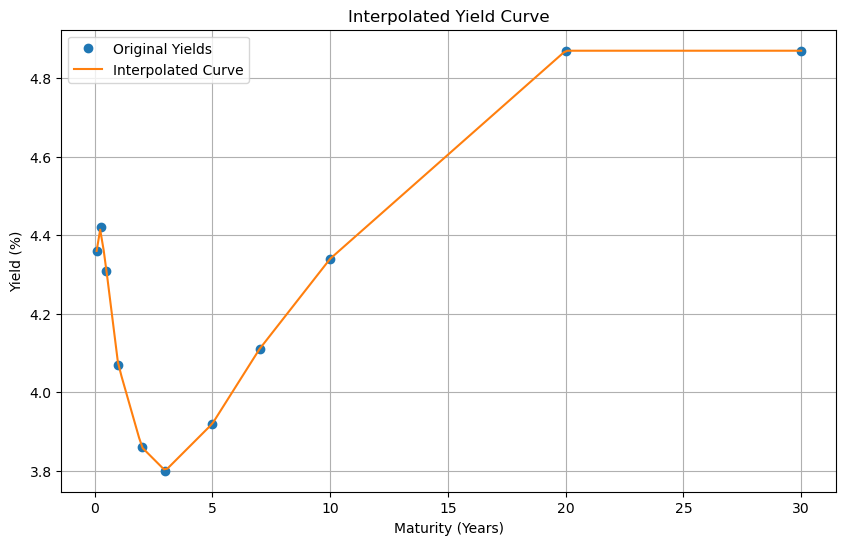

In [9]:
import numpy as np

# Generate many points between 0 and 30Y
x_smooth = np.linspace(min(x), max(x), 200)
y_smooth = interp_func(x_smooth)

# Plot original points + interpolated smooth curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label="Original Yields")
plt.plot(x_smooth, y_smooth, '-', label="Interpolated Curve")
plt.title("Interpolated Yield Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Get the interpolated yield at 4.5 years
interp_func(4.5)

array(3.89)

In [11]:
# Compute spread between 2s and 7.5s
interp_func(7.5) - interp_func(2)

np.float64(0.28833333333333355)

In [16]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Create dropdown
date_selector = widgets.Dropdown(
    options=list(all_yield_curves.keys()),
    description='Date:',
    value=list(all_yield_curves.keys())[-1]
)

# Create output container
output = widgets.Output()

# Define update function
def update_curve(change):
    with output:
        output.clear_output(wait=True)
        selected_date = change['new']
        curve = all_yield_curves[selected_date]
        
        plt.figure(figsize=(10, 6))
        plt.plot(curve["Maturity (Years)"], curve["Yield (%)"], marker='o')
        plt.title(f"US Treasury Yield Curve - {selected_date}")
        plt.xlabel("Maturity (Years)")
        plt.ylabel("Yield (%)")
        plt.grid(True)
        plt.show()

# Attach observer
date_selector.observe(update_curve, names='value')

# Display all widgets
display(date_selector, output)

# Trigger initial display
update_curve({'new': date_selector.value})


Dropdown(description='Date:', index=16, options=('2025-06-17', '2025-06-18', '2025-06-20', '2025-06-23', '2025…

Output()